In [1]:
import numpy as np
import gym
import tensorflow as tf
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Input

C:\Users\gupta\anaconda3\lib\site-packages\ale_py\roms\__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()


## Pong

Deep Q learning with memory buffer - varying probs to oversample minority (cases when you win), action every 4 frame, and linear annealing

In [2]:
# function to convert each image into lesser size
def prepro(I):
    # preprocess each frame for learning
    # save some memory and computation
    # pre-process the image from a 210x160x3 uint8 frame into an (80x80) float array 
    I = I[35:195,:,:].copy() # crop the top of the image...score image doesn't matter for how to play
    I = I[::2,::2,0].copy()
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.array(I.copy())

C:\Users\gupta\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def create_model(height,width,channels):
    # we cannot simply have 3 output nodes because we want to put a weight on each node's impact to the objective
    # that is different for each data point.  the only way to achieve this is to have 3 output layers, each having 1 node
    # the effect is the same, just the way TF/keras handles weights is different
    imp = Input(shape=(height,width,channels))
    mid = Conv2D(32,(8,8),strides=4,activation='relu')(imp)
    mid = Conv2D(64,(4,4),strides=2,activation='relu')(mid)
    mid = Conv2D(64,(3,3),strides=1,activation='relu')(mid)
    mid = Flatten()(mid)
    mid = Dense(512,activation='relu')(mid)
    mid = Dense(256,activation='relu')(mid)
    out0 = Dense(1,activation='linear',name='out0')(mid)
    out1 = Dense(1,activation='linear',name='out1')(mid)
    out2 = Dense(1,activation='linear',name='out2')(mid)
    model = Model(imp,[out0,out1,out2]) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=25e-6),loss=tf.keras.losses.Huber())
    
    return model

In [6]:
frames_to_net = 4              # how many previous frames will we feed the NN
possible_actions = [0,2,3]
mod = create_model(80,80,frames_to_net)
mod.call = tf.function(mod.call,experimental_relax_shapes=True)

mod.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 80, 4)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 19, 19, 32)   8224        ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 8, 8, 64)     32832       ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 6, 6, 64)     36928       ['conv2d_4[0][0]']               
                                                                                            

In [11]:
def play1game(model,ep):
    env0 = gym.make("Pong-v0")
    pix = env0.reset()
    pix = prepro(pix)
    frames_this_game = 0
    feed = np.zeros((1,80,80,frames_to_net))
    feed[0,:,:,0] = pix.copy() # 0 is the most recent frame t; 1 the previous one t+1 and so one
    
    frame_array = []
    action_array = []
    reward_array = []
    
    score = 0
    feed_reward = 0
    action = np.random.choice(3)
    action0 = possible_actions[action]
    done = False
    while not done:
        # updating action every 4 frames
        # but taking that action for the 4 frames just not using the prediction for action
        if (frames_this_game % 4 == 0) & (frames_this_game != 0):
            
            frame_array.append(feed)
            action_array.append(action)
            reward_array.append(feed_reward)
            
            if np.random.random() < ep:
                action = np.random.choice(3)
            else:
                vf = mod(feed,training=False)
                vf = [vf[0][0,0].numpy(),vf[1][0,0].numpy(),vf[2][0,0].numpy()]
                action = np.argmax(vf)
                
            feed_reward = 0
            
        action0 = possible_actions[action]
        pix_new, reward, done, info = env0.step(action0)

        pix = prepro(pix_new)
        frames_this_game += 1

        for f in range(1,frames_to_net):
            feed[0,:,:,frames_to_net-f] = feed[0,:,:,frames_to_net-f-1].copy()
        feed[0,:,:,0] = pix.copy()
        score += reward
    return frame_array, action_array, reward_array, score

In [21]:
# testing the likelihood of taking each action without any training
frames, actions, rewards, score = play1game(mod,0.5)
print(np.mean(np.array(actions)==0),np.mean(np.array(actions)==1),np.mean(np.array(actions)==2))


0.36904761904761907 0.4087301587301587 0.2222222222222222


In [22]:
# discounting factor
delt = 0.99

# setting up variable for memory buffer
ngames = 1000
# ngames = 100
nbatch = 64
buffn = 20000
warmupgames = 50
len_buff = 0
buffer = {'frames':[],'actions':[], 'rewards':[]}

# eps vector for each gradient for linear annealing
epsvec = np.linspace(0.5,0.05,250)
output_qdl = {'game':[-1]*ngames, 'score':[-100]*ngames, 'time':[-1]*ngames}

In [24]:
overall_start = time.time()

for game in range(ngames):
    if game < len(epsvec):
        eps = epsvec[game]
    else:
        eps = epsvec[-1]
    
    start = time.time()
    frames, actions, rewards, score = play1game(mod,eps)
    buffer['frames'] += frames.copy()
    buffer['actions'] += actions.copy()
    buffer['rewards'] += rewards.copy()
    len_buff += len(actions)
    if len_buff > buffn:
        excess = len_buff - buffn
        buffer['frames'] = buffer['frames'][excess:].copy()
        buffer['actions'] = buffer['actions'][excess:].copy()
        buffer['rewards'] = buffer['rewards'][excess:].copy()
        len_buff = len(buffer['actions'])
    
    # rewards = np.array(rewards)
    # actions = np.array(actions)
    
    nframes = len(frames)
    current_frames = np.zeros((nframes,80,80,frames_to_net))
    future_frames = np.zeros((nframes,80,80,frames_to_net))
  
    if game >= warmupgames:
        # choosing the frames from memory buffer based on the reward
        # weighing the frames 
        # something like over/under sampling in unbalanced class
        prob = np.ones(len_buff)
        prob[np.array(buffer['rewards']) > 0] = 10.0
        prob /= np.sum(prob)
        which_choose = np.random.choice(len_buff,size=nframes,replace=False,p=prob)
    
        rewards = np.zeros(nframes)
        actions = np.zeros(nframes)
        for grab in range(nframes):
            rewards[grab] = buffer['rewards'][which_choose[grab]]
            actions[grab] = buffer['actions'][which_choose[grab]]
            # creating frame - current t (for prediction) and t+1 (for truth)
            current_frames[grab,:,:,:] = buffer['frames'][which_choose[grab]].copy()
            current_frames[grab,:,:,:] = buffer['frames'][which_choose[grab] - 1].copy()
            
#             for f in range(frames_to_net):
#                 if grab-f > 0:
#                     current_frames[grab,:,:,f] = buffer['frames'][which_choose[grab]-f].copy()
#                 if (grab-f+1 > 0) & (grab-f+1 < len_buff-1):
#                     future_frames[grab,:,:,f] = buffer['frames'][which_choose[grab]-f+1].copy()


    target_vf = mod.predict(future_frames)

    # vectors of truth
    y0 = np.zeros((nframes,1))
    y1 = np.zeros((nframes,1))
    y2 = np.zeros((nframes,1))
    
    # weight for training neural network based on the "truth"
    weight0 = np.zeros(nframes)
    weight1 = np.zeros(nframes)
    weight2 = np.zeros(nframes)
  

    for grab in range(nframes):
        rhs = rewards[grab]
        # terminal condition will be when we win a game
        # 
        if rhs == 0:
            rhs = delt*np.max([target_vf[0][grab],target_vf[1][grab],target_vf[2][grab]])
        if actions[grab] == 0:
            y0[grab,0] = rhs
            weight0[grab] = 1
        elif actions[grab] == 1:
            y1[grab,0] = rhs
            weight1[grab] = 1
        else:
            y2[grab,0] = rhs
            weight2[grab] = 1
  
    mod.fit(current_frames,[y0,y1,y2],epochs=1,batch_size=nbatch,verbose=0,sample_weight={'out0':weight0,'out1':weight1,'out2':weight2},use_multiprocessing=True)
    stop = time.time()
    # print([game, score, eps, stop-start])
    
    output_qdl['game'][game] = game
    output_qdl['score'][game] = score
    output_qdl['time'][game] = time
    
    if game % 10 == 0:
        print('Game number ', game, [score, eps, stop-start])

overall_end = time.time()
print('total run time, ', (overall_end - overall_start)/60, 'minutes')

Game number  0 [-21.0, 0.5, 2.203951358795166]
Game number  10 [-21.0, 0.4819277108433735, 1.9441626071929932]
Game number  20 [-21.0, 0.463855421686747, 1.8434054851531982]
Game number  30 [-21.0, 0.4457831325301205, 2.075533628463745]
Game number  40 [-21.0, 0.42771084337349397, 2.4606990814208984]
Game number  50 [-21.0, 0.40963855421686746, 2.5529916286468506]
Game number  60 [-21.0, 0.39156626506024095, 2.0724635124206543]
Game number  70 [-21.0, 0.37349397590361444, 1.8907365798950195]
Game number  80 [-21.0, 0.35542168674698793, 2.1993179321289062]
Game number  90 [-21.0, 0.3373493975903614, 1.8546216487884521]
Game number  100 [-21.0, 0.3192771084337349, 2.5508949756622314]
Game number  110 [-21.0, 0.3012048192771084, 2.0136959552764893]
Game number  120 [-20.0, 0.2831325301204819, 2.2816162109375]
Game number  130 [-21.0, 0.2650602409638554, 1.8680012226104736]
Game number  140 [-21.0, 0.24698795180722893, 2.417581081390381]
Game number  150 [-21.0, 0.22891566265060243, 1.8934

In [19]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
mod.save('saved_model/dqlv2')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: saved_model/dqlv2\assets


C:\Users\gupta\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([75.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  5.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

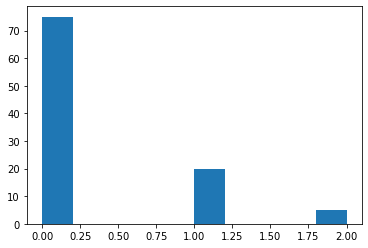

In [62]:
import matplotlib.pyplot as plt
plt.hist([x+21 for x in output_qdl['score']])